In [1]:
import pandas as pd
import numpy as np
import paths, utils
import nibabel as nib
from scipy.stats import pearsonr
from nilearn import plotting
import matplotlib.pyplot as plt

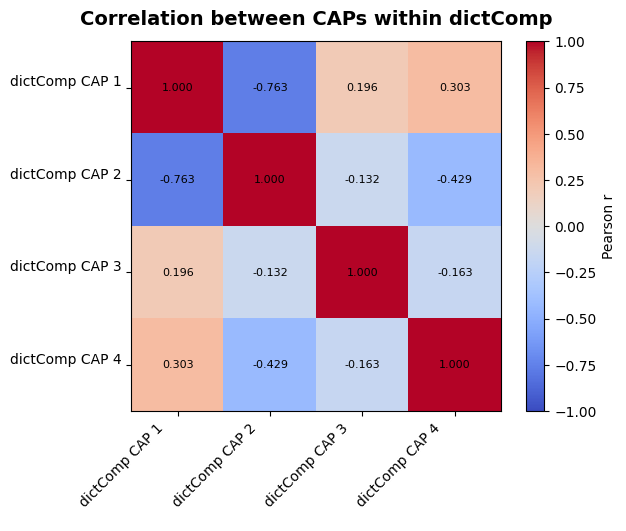

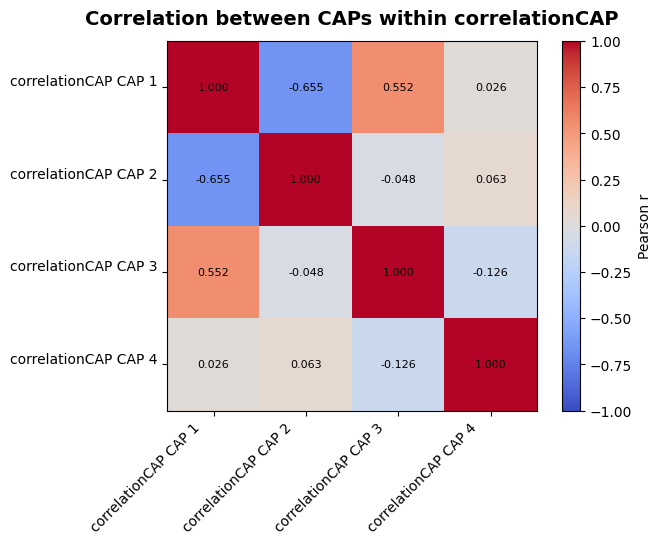

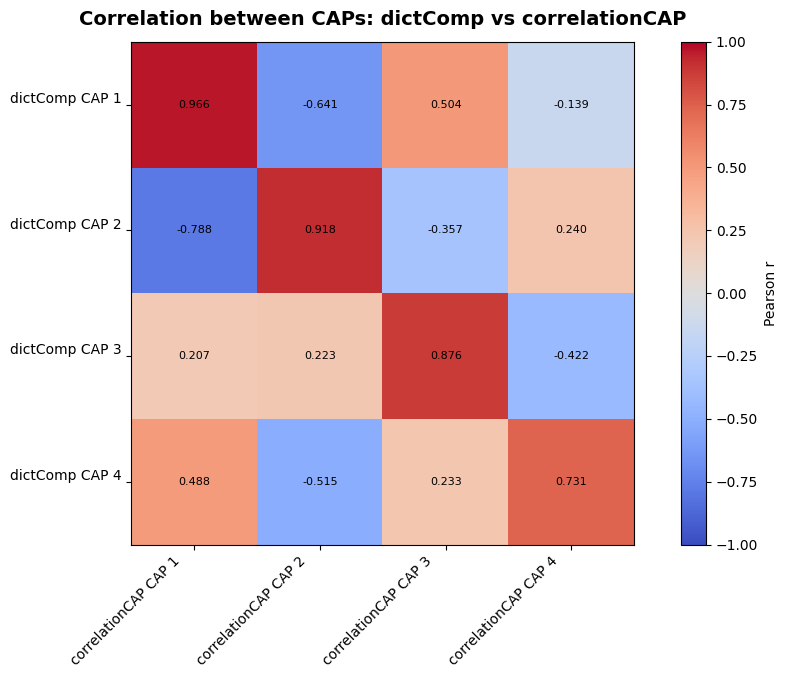

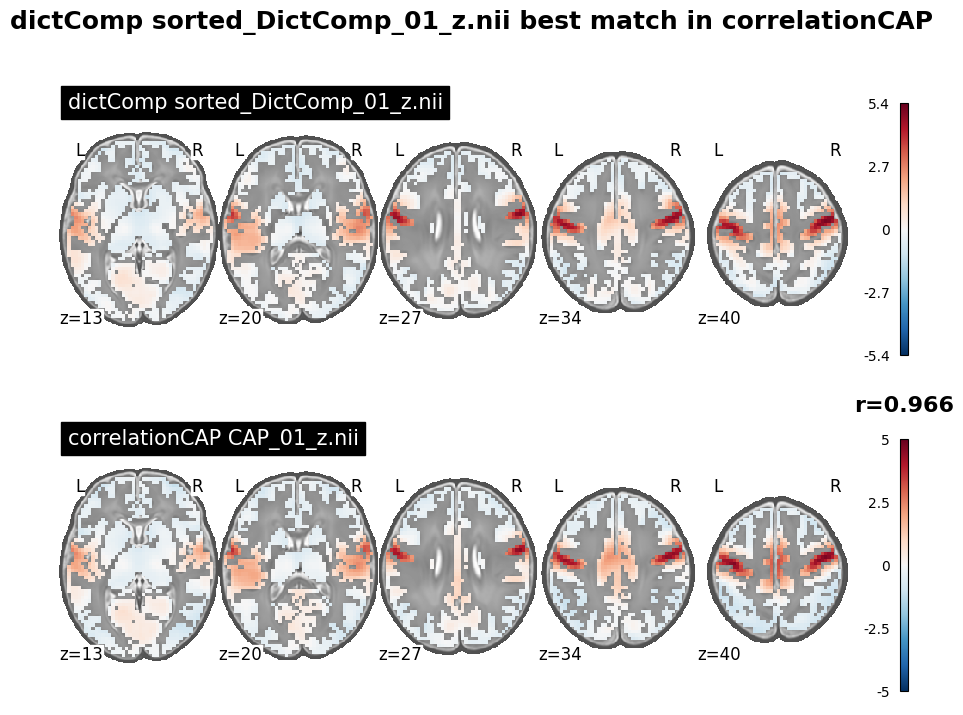

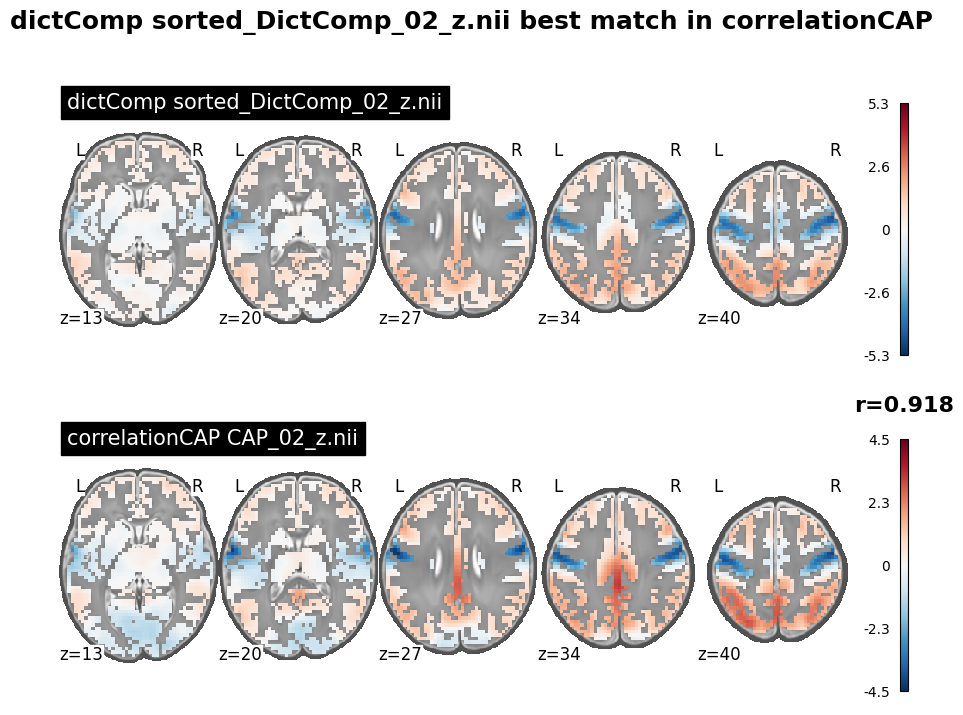

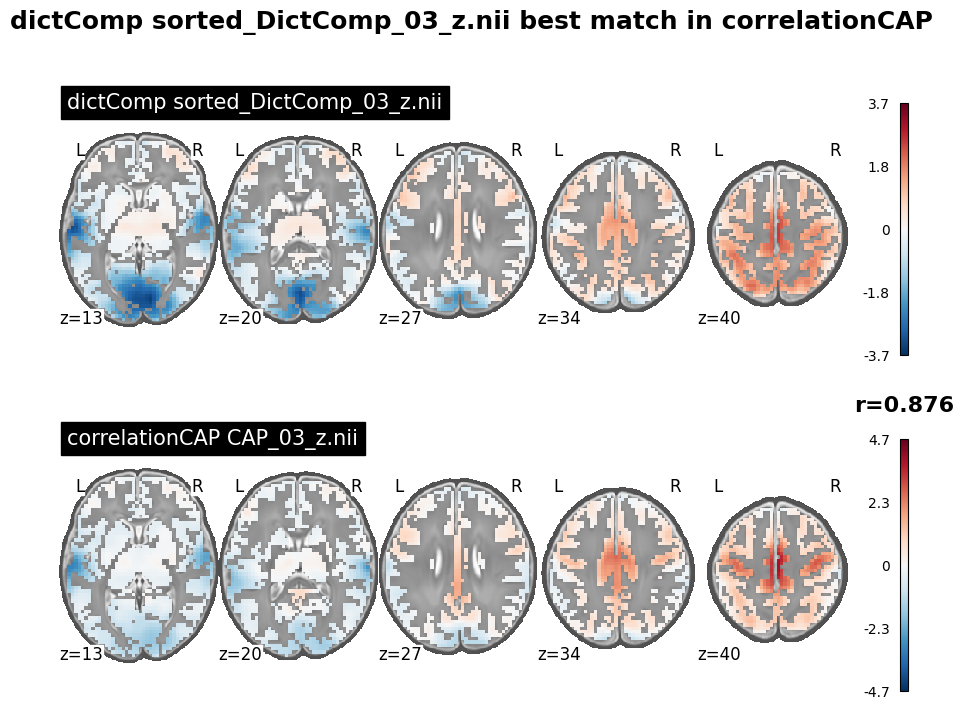

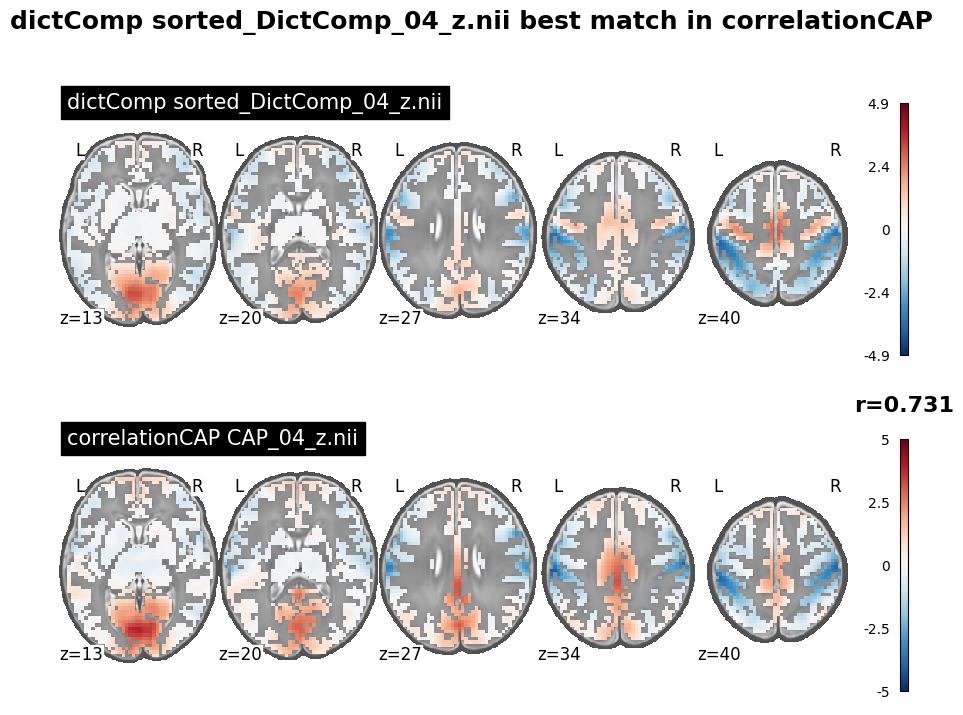

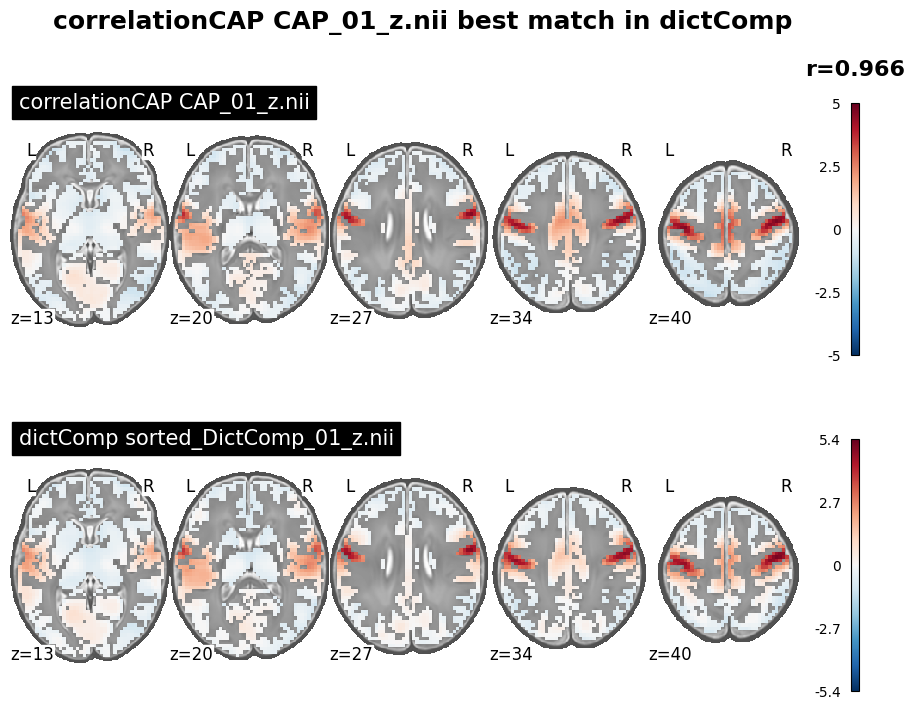

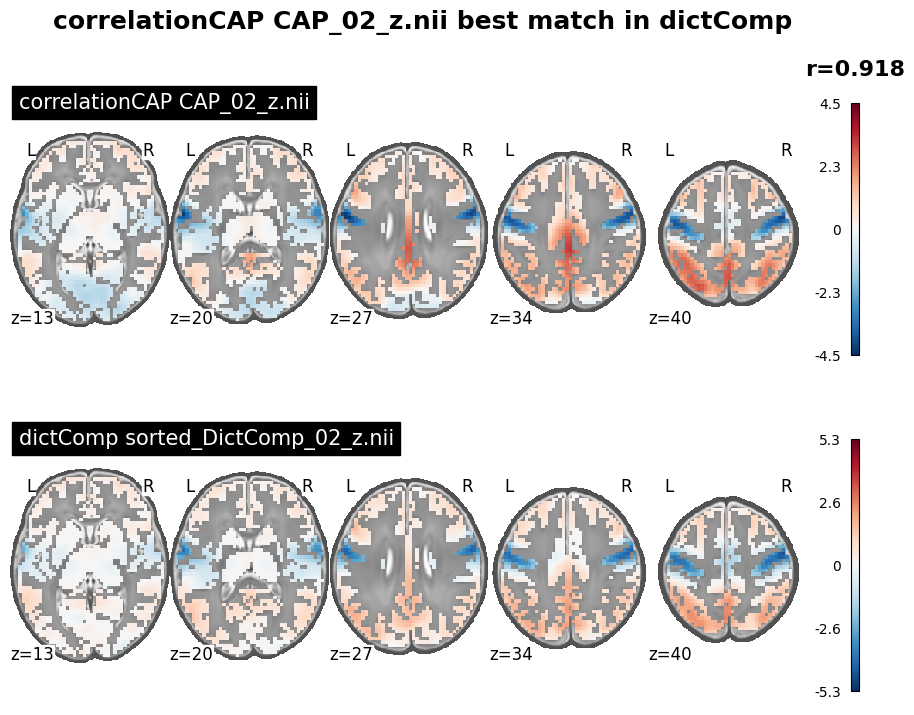

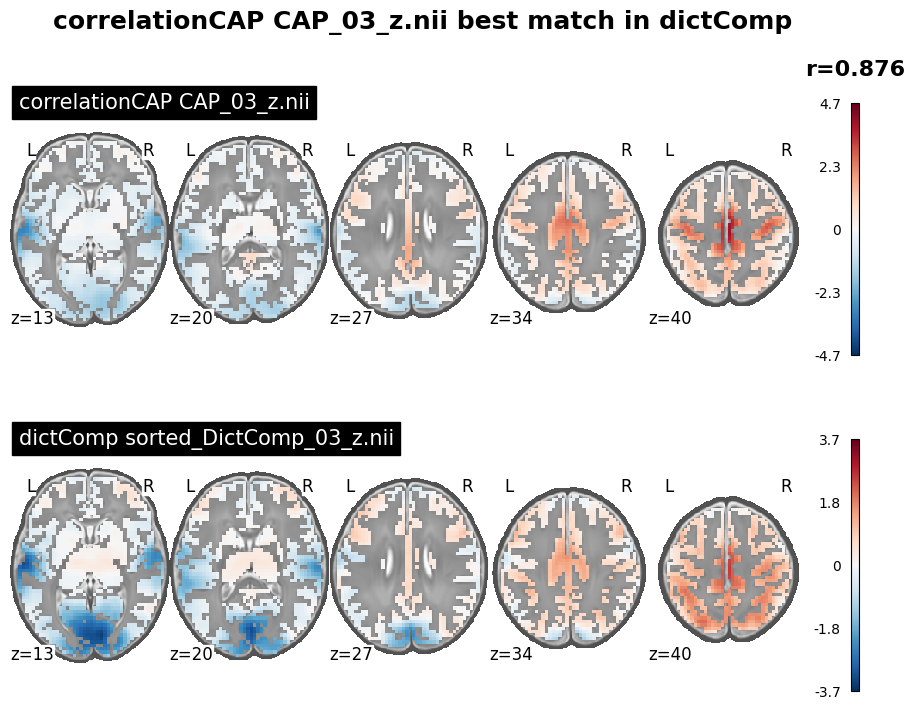

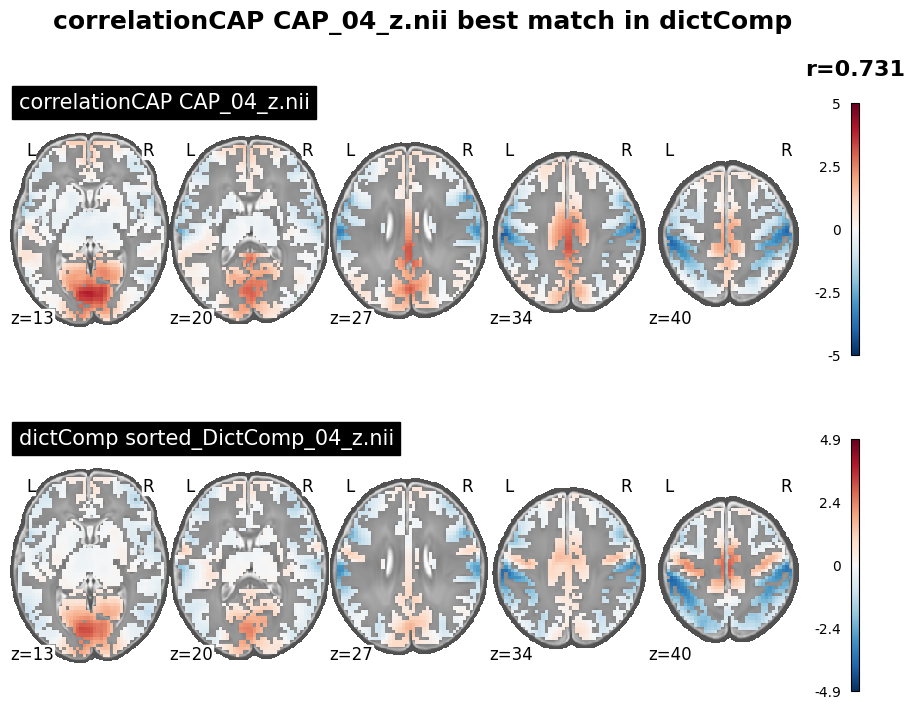

Comparison results saved in results/server_sample_derivatives/comparisons/dictComp_vs_correlationCAP


In [3]:
folderA = "DictLr_Ncomps-4_PosCode-True_Alpha-2.0_Tvalue-15_Act-pos_n-34"
folderA_name = "dictComp"
folderA_glob = "sorted_DictComp_*_z.nii"

folderB = "cust_kmeans_dist-correlation_ttype-percentage_tvalue-15_k-4_ninits-50_activation-pos_n-34"
folderB_name = "correlationCAP"
folderB_glob = "CAP_*_z.nii"

utils.compare_folder(
    folderA=folderA,
    folderB=folderB,
    folderA_name=folderA_name,
    folderB_name=folderB_name,
    folderA_glob=folderA_glob,
    folderB_glob=folderB_glob,
    path_prefix=paths.results / "server_sample_derivatives"
)